In [132]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from scipy.special import erfc
import time
import copy
import random
import typing

In [133]:
def analytical_solution(x, t, D, max_range=10):
    """
    
    D: diffusion coefficient
    x: space/place
    t: time at which to evaluate
    max_range: """

    sum_analytical = np.zeros_like(x)
    for i in range(max_range):
        sum_analytical += erfc((1 - x + 2 * i) / (2*np.sqrt(D*t))) - erfc((1 + x + 2 * i) / (2*np.sqrt(D*t)))

    return sum_analytical

In [134]:
def initialize_grid(N: int):
    '''
    Initialize a 2D grid with NXN dimensions 
    '''
    grid = np.zeros((N, N))
    grid[-1, :] = 1.0
    
    return grid

In [135]:
def get_next_grid(grid, N, dt, D, dx, method, omega):
  new_grid = np.copy(grid)
  if method == 'Explicit':
    for i in range(1, N-1):
        for j in range(N):
          new_grid[i,j] = grid[i,j]+ (dt * D / dx**2) * (grid[i-1, j] + grid[i+1, j] + grid[i, (j-1) % N] + grid[i, (j+1) % N]- 4* grid[i,j])
    return new_grid
  
  elif method == 'Jacobi':
    maximum_difference = 0
    for i in range(1, N-1):
       for j in range(N):
         new_grid[i, j] = 0.25 * (grid[i-1, j] + grid[i+1, j] + grid[i, (j-1) % N] + grid[i, (j+1) % N])
         maximum_difference = max(maximum_difference, abs(new_grid[i, j] - grid[i, j]))
    return new_grid, maximum_difference  
    
  elif method == 'Gauss-Seidel':
    maximum_difference = 0
    for i in range(1, N-1):
        for j in range(N):
            old_value = new_grid[i, j]
            new_grid[i, j] = 0.25 * (new_grid[i-1, j] + grid[i+1, j] + new_grid[i, (j-1) % N] + grid[i, (j+1) % N])
            maximum_difference = max(maximum_difference, abs(new_grid[i, j] - old_value))
    return new_grid, maximum_difference
  
  elif method == 'SOR':
    maximum_difference = 0
    for i in range(1, N-1):
        for j in range(N):
            old_value = grid[i, j]
            gauss_seidel_value = 0.25 * (new_grid[i-1, j] + grid[i+1, j] + new_grid[i, (j-1) % N] + grid[i, (j+1) % N])
            new_grid[i, j] = (1 - omega) * old_value + omega * (gauss_seidel_value)
            maximum_difference = max(maximum_difference, abs(new_grid[i, j] - old_value))
    return new_grid, maximum_difference
  

In [195]:
def simulate_diffusion_2d(N, D, dx, dt, T, method="Explicit", omega=1.85, tol= 1e-5, save_interval=100):
    """Simulates the process of diffusion through the entire grid 
    omega: relaxation parameter
    save_interval; interval at which the grid is saved"""

    c = initialize_grid(N)
    c_history = [c.copy()]

    n_steps = int(T / dt)
    time_points = [0.0]
    special_times = [0.001, 0.01, 0.1, 1.0]

    # Compute and store the grid and time step
    if method == 'Explicit':
      for step in range(1, n_steps + 1):
          c = get_next_grid(c, N, dt, D, dx, method=method, omega=omega)
          current_time = step * dt

          if (step % save_interval == 0) or any(abs(current_time - t) < dt for t in special_times):
              time_points.append(current_time)
              c_history.append(c.copy())
      
      return time_points, c_history
    
    elif method in ['Jacobi', 'Gauss-Seidel', 'SOR']:
      iters = 0
      while True:  
          c, max_diff = get_next_grid(c, N, dt, D, dx, method=method, omega=omega)
          
          if iters % save_interval == 0:
              c_history.append(c.copy())
              
          if max_diff < tol:
              print(f"Converged after {iters} iterations")
              break

              
          iters += 1
          
      return iters,c_history

   

In [137]:
def validate_against_analytical(x_points, times, D, c_history, N):

    plt.figure(figsize=(12, 8))
    
    mid_x = N // 2
    
    for i, t in enumerate(times):
        if t > 0:  
            numerical = c_history[i][:, mid_x]
            
            # Calculate analytical solution
            analytical = np.array([analytical_solution(x, t, D) for x in x_points])
            
            # Plot both solutions
            plt.plot(x_points, numerical, 'o-', label=f'Numerical, t={t:.3f}')
            plt.plot(x_points, analytical, '--', label=f'Analytical, t={t:.3f}')
    
    plt.xlabel('y position')
    plt.ylabel('Concentration c(y)')
    plt.title('Comparison between numerical and analytical solutions')
    plt.legend()
    plt.grid(True)
    plt.savefig('validation_plot.png', dpi=300)
    plt.show()

In [138]:
def plot_2d_concentration(times, c_history, N, dx):

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    x = np.linspace(0, (N-1)*dx, N)
    y = np.linspace(0, (N-1)*dx, N)
    X, Y = np.meshgrid(x, y)
    
    for i, (t, c) in enumerate(zip(times, c_history)):
        if i < len(axes):
            ax = axes[i]
            im = ax.pcolormesh(X, Y, c, cmap='viridis', shading='auto')
            ax.set_title(f't = {t:.3f}')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            fig.colorbar(im, ax=ax, label='Concentration')
    
    plt.tight_layout()
    plt.savefig('concentration_plots.png', dpi=300)
    plt.show()

In [139]:
def create_animation(times, c_history, N, dx):
    """
    Create an animation of the concentration field over time
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    x = np.linspace(0, (N-1)*dx, N)
    y = np.linspace(0, (N-1)*dx, N)
    X, Y = np.meshgrid(x, y)
    
    # Initial plot
    im = ax.pcolormesh(X, Y, c_history[0], cmap='viridis', shading='auto', vmin=0, vmax=1)
    title = ax.set_title(f't = {times[0]:.5f}')
    fig.colorbar(im, ax=ax, label='Concentration')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    def update(frame):
        im.set_array(c_history[frame].ravel())
        title.set_text(f't = {times[frame]:.5f}')
        return [im, title]
    
    ani = FuncAnimation(fig, update, frames=range(len(times)), blit=True)
    ani.save('diffusion_animation.gif', writer='pillow', fps=15)
    plt.show()
    
    return ani

In [140]:
def compare_analytic_solutions(N, L, D, dx, dt, T, method = 'Explicit'):
    time_points, c_history = simulate_diffusion_2d( N, D, dx, dt, T, method, save_interval=100)
    x_points = np.linspace(0, L, N)
    target_times = [0, 0.001, 0.01, 0.1, 1.0]
    selected_indices = []
    selected_times = []

    for target in target_times:
        idx = np.argmin(np.abs(np.array(time_points) - target))#Finding indices which are closest to the target timesteps
        selected_indices.append(idx)
        selected_times.append(time_points[idx])

    validate_against_analytical(x_points, [time_points[i] for i in selected_indices], D, [c_history[i] for i in selected_indices], N)
    plot_2d_concentration([time_points[i] for i in selected_indices],[c_history[i] for i in selected_indices], N, dx)
    ani = create_animation(time_points, c_history, N, dx)

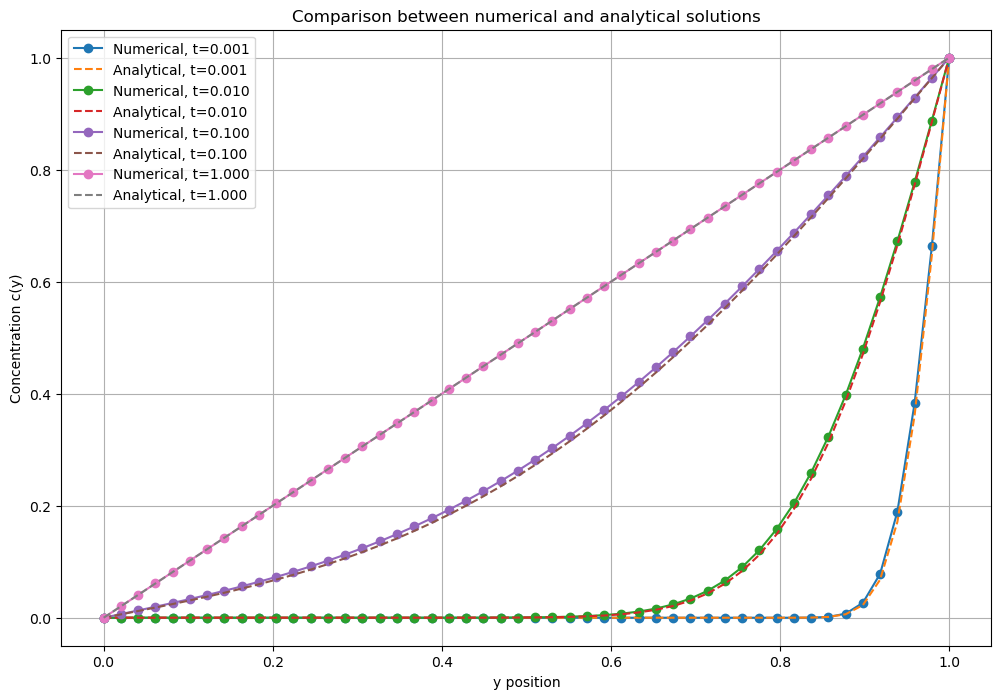

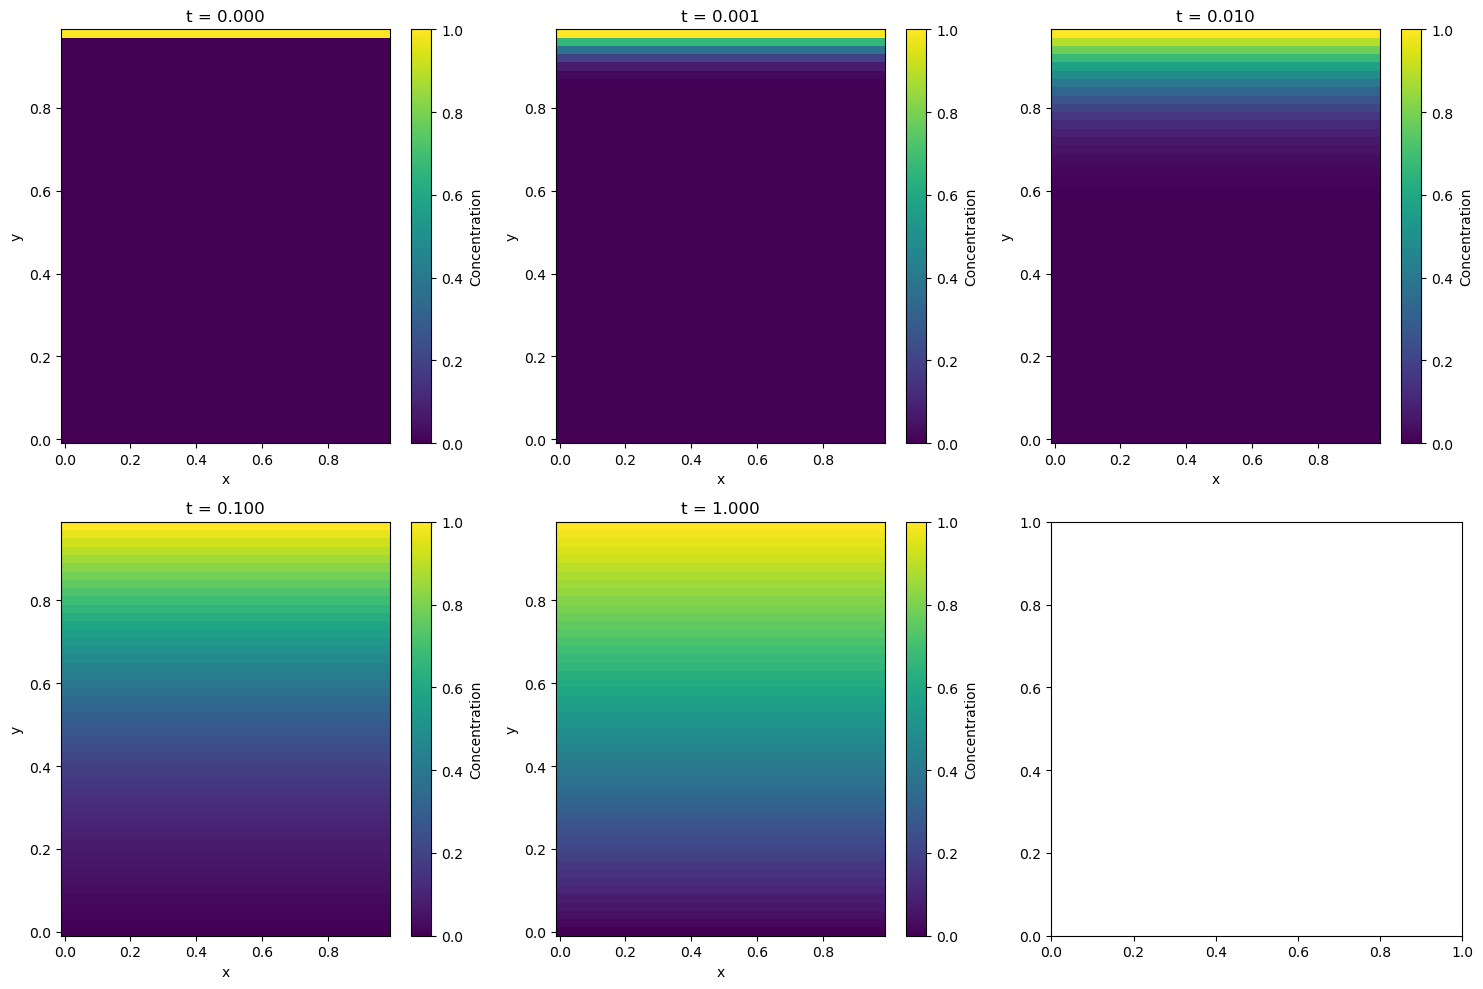

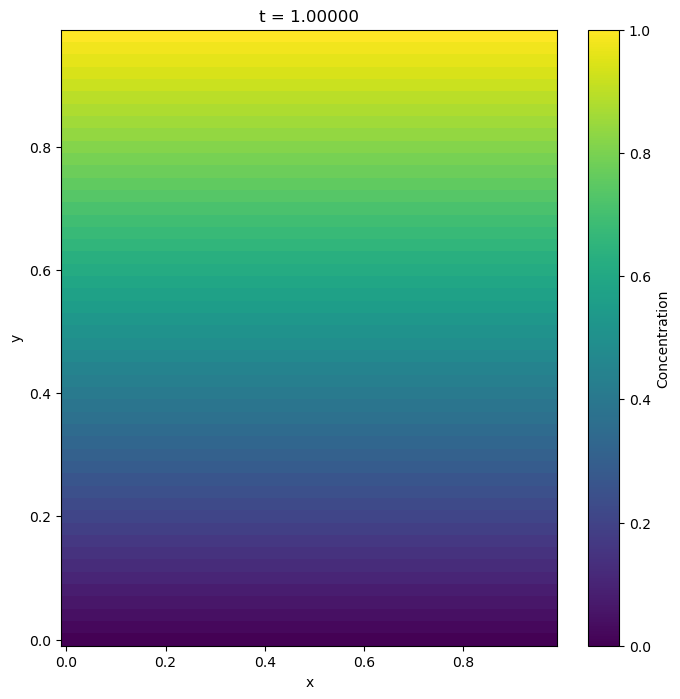

In [141]:
N = 50      # Number of grid points (must be square grid for provided update function)
L = 1.0   # Domain size
dx= L/(N)  # Grid spacing
D = 1.0              # Diffusion coefficient

# # Stability-limited time step
dt = 0.25 * dx**2 / D  
T = 1.0   
compare_analytic_solutions(N, L, D, dx, dt, T, method = 'Explicit')
# time_points, c_history = simulate_diffusion_2d( N, D, dx, dt, T, save_interval=100)
# time_points, c_history = simulate_diffusion_2d( N, D, dx, dt, T,method='Jacobi',tol =1e-5,save_interval=100)

In [163]:
def test_methods(N, D, dx, dt, T, L):
    methods = ["Jacobi", "Gauss-Seidel", "SOR"]
    # methods = ['SOR']
    # methods = ['Explicit']
    omega = 1.7  # Relaxation factor for SOR
    for method in methods:
        time_points, c_history = simulate_diffusion_2d(N, D, dx, dt, T, method=method, omega=omega)

        x_points = np.linspace(0, L, N)
        
        selected_index = -1
        print(time_points[-1])
        selected_times = [time_points[selected_index]]
        print(selected_times)
        selected_c_history = [c_history[selected_index]]

        validate_against_analytical(x_points, selected_times, D, selected_c_history, N)

In [166]:
time_points, c_history = simulate_diffusion_2d(N, D, dx, dt, T, method ='SOR', omega=1.7)
c_history = np.array(c_history)
mid_x = len(c_history[-1]) // 2  # Midpoint in x-direction
 
c_values = [row[mid_x] for row in c_history[-1]]
analytic_vals=[]
# print(len(c_values))
y_values = np.linspace(0, L, N)
for x in y_values:
    analytic_vals.append(float(analytical_solution(x, 1, D)))
print(analytic_vals)


1232
Converged at t = 0.1233 with max_diff = 9.999717887065884e-09
[0.0, 0.020406053560908667, 0.04081211579104521, 0.061218195324013853, 0.08162430072231763, 0.1020304404421737, 0.12243662279876386, 0.14284285593206758, 0.163249147773411, 0.18365550601287667, 0.2040619380677026, 0.22446845105180427, 0.24487505174654114, 0.26528174657285103, 0.28568854156486434, 0.30609544234510966, 0.3265024541014088, 0.34690958156555984, 0.3673168289938913, 0.38772420014977427, 0.4081316982881557, 0.428539326142185, 0.44894708591198196, 0.4693549792555964, 0.4897630072821943, 0.5101711705475003, 0.5305794690515147, 0.5509879022385126, 0.5713964689993278, 0.5918051676759106, 0.6122139960681414, 0.6326229514428711, 0.6530320305451518, 0.6734412296116131, 0.6938505443859257, 0.7142599701362928, 0.7346695016748916, 0.7550791333791941, 0.7754888592150696, 0.79589867276158, 0.8163085672373662, 0.8367185355285128, 0.857128570217782, 0.8775386636150907, 0.8979488077891122, 0.9183589945998685, 0.9387692157321

312
Converged at t = 0.0313 with max_diff = 9.337928931152373e-06


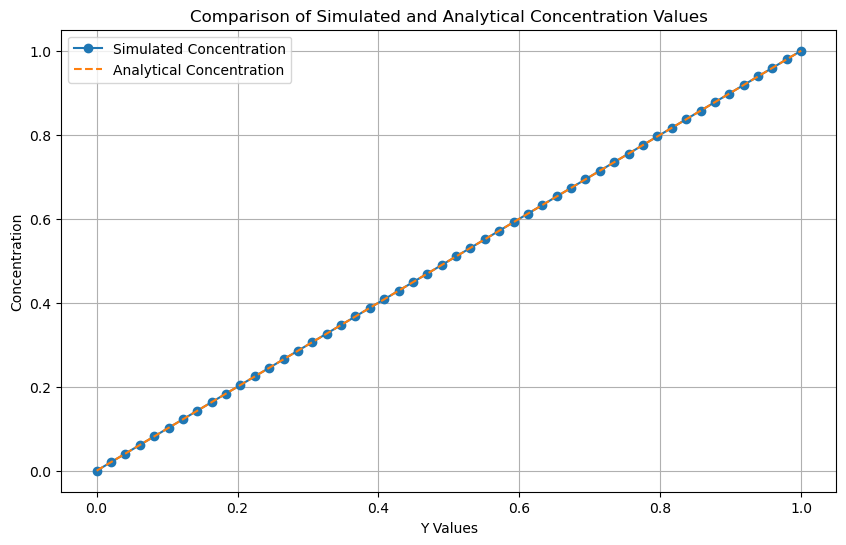

In [171]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have your `c_values` and `y_values`
time_points, c_history = simulate_diffusion_2d(N, D, dx, dt, T, method='SOR', omega=1.9)
c_history = np.array(c_history)
mid_x = len(c_history[-1]) // 2  # Midpoint in x-direction

c_values = [row[mid_x] for row in c_history[-1]]
y_values = np.linspace(0, L, N)

# Calculate analytical values at the same x points
analytic_vals = [float(analytical_solution(y, T, D)) for y in y_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y_values, c_values, label='Simulated Concentration', marker='o')
plt.plot(y_values, analytic_vals, label='Analytical Concentration', linestyle='--')
plt.xlabel('Y Values')
plt.ylabel('Concentration')
plt.title('Comparison of Simulated and Analytical Concentration Values')
plt.legend()
plt.grid()
plt.show()


In [172]:
def compare_numerical_methods(N, D, dx, dt, T, L, methods=['Jacobi', 'Gauss-Seidel', 'SOR'], tol= 1e-5, omega=1.9):
    """
    Compares numerical methods for solving the diffusion equation.
    Plots the concentration profiles for each method against the analytical solution.
    
    Parameters:
    - N: Number of grid points
    - D: Diffusion coefficient
    - dx: Spatial step size
    - dt: Time step size
    - T: Final simulation time
    - L: Length of the domain
    - methods: List of numerical methods to compare
    - omega: Relaxation parameter for SOR
    """
    y_values = np.linspace(0, L, N)
    analytic_vals = [float(analytical_solution(y, T, D)) for y in y_values]
    
    plt.figure(figsize=(10, 6))
    
    for method in methods:
        iters, c_history = simulate_diffusion_2d(N, D, dx, dt, T, method=method, tol= tol, omega=omega)
        c_history = np.array(c_history)
        mid_x = len(c_history[-1]) // 2  # Midpoint in x-direction
        c_values = [row[mid_x] for row in c_history[-1]]
        
        plt.plot(y_values, c_values, label=f'{method} Method', marker='o')
    
    plt.plot(y_values, analytic_vals, label='Analytical Solution', linestyle='--', color='black')

    plt.xlabel('Y Values')
    plt.ylabel('Concentration')
    plt.title(f'Comparison of {method} Method with Analytical Solution after {iters} iterations')
    plt.legend()
    plt.grid()
    plt.show()

Converged after 4067 iterations


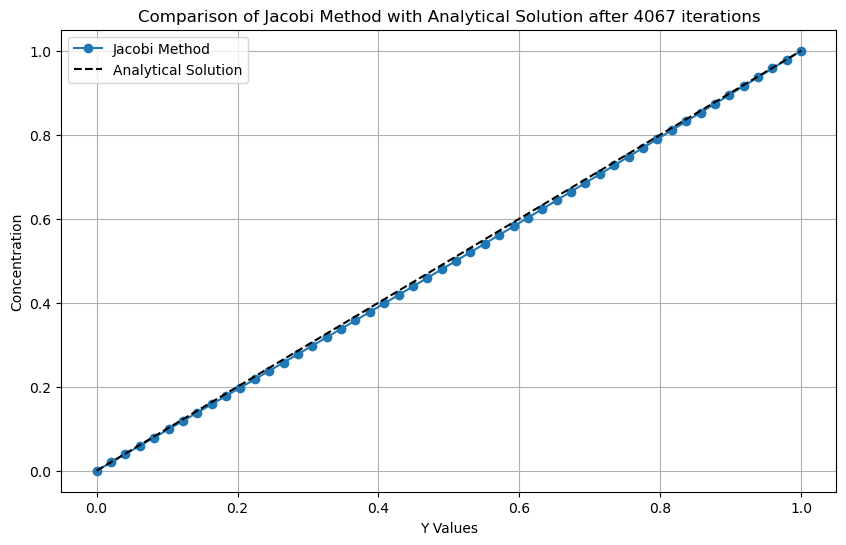

In [178]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['Jacobi'])

Converged after 2406 iterations


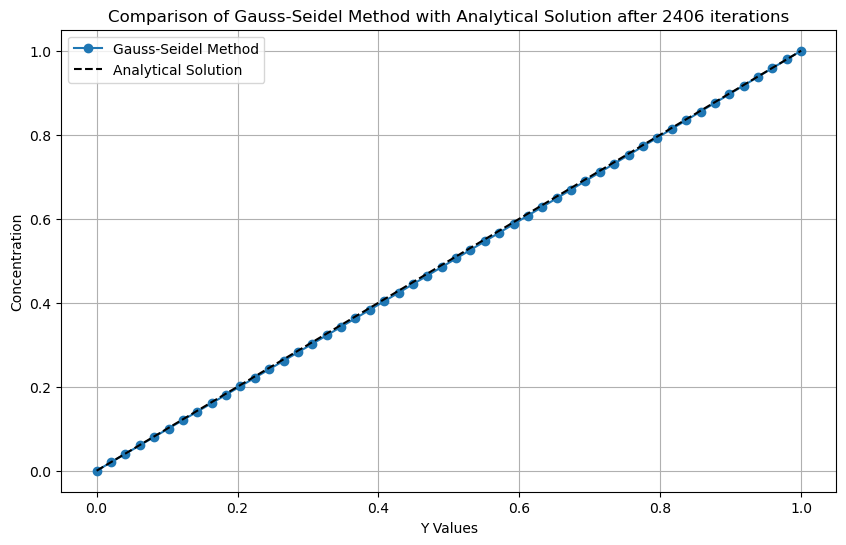

In [179]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['Gauss-Seidel'])

Converged after 424 iterations


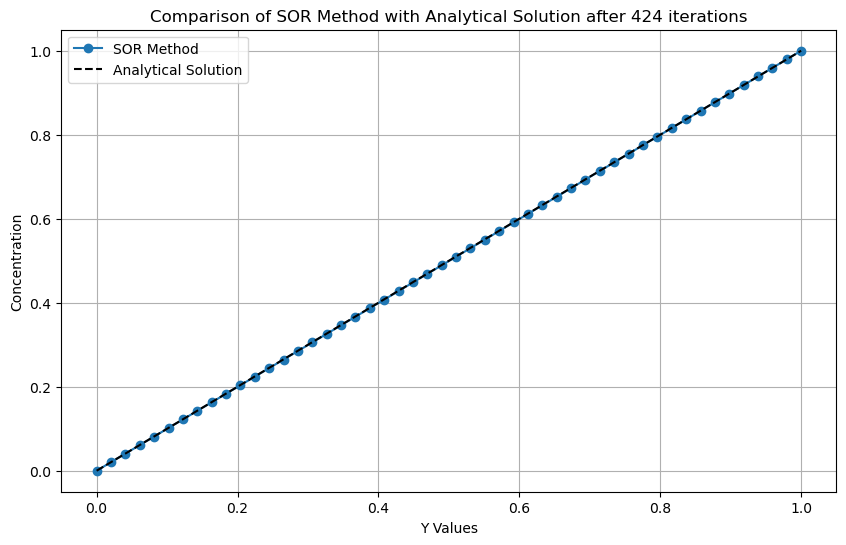

In [180]:
compare_numerical_methods(N, D, dx, dt, T, L, methods=['SOR'], omega=1.8)

In [197]:
def compare_tolerance_methods(N, D, dx, dt, T, omega=1.9, tol_values=None):
    if tol_values is None:
        tol_values = [1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12]  # Different tolerances

    methods = ['Jacobi', 'Gauss-Seidel', 'SOR']
    iter_counts = {method: [] for method in methods}

    for method in methods:
        for tol in tol_values:
            iters, num_iterations = simulate_diffusion_2d(N, D, dx, dt, T, method=method, omega=omega, tol=tol, return_iters=True)
            iter_counts[method].append(num_iterations)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    for i, method in enumerate(methods):
        axes[i].plot(tol_values, iter_counts[method], marker='o', label=method)
        axes[i].set_xscale("log")
        axes[i].set_xlabel("Tolerance")
        axes[i].set_ylabel("Iterations")
        axes[i].set_title(f"{method} Method")
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()



In [198]:
tol_values = np.logspace(-4, -12, 5)
# omega_values = {'SOR': 1.7, 'Gauss-Seidel': 1.0, 'Jacobi': 1.0}
# def simulate_diffusion_2d(N, D, dx, dt, T, method="Explicit", omega=1.85, tol= 1e-5, save_interval=100)
compare_tolerance_vs_iterations(N, D, dx, dt, T, tol_values)

Converged after 6307 iterations
6307
Converged after 10788 iterations
10788
Converged after 15268 iterations
15268
Converged after 19749 iterations
19749
Converged after 24226 iterations
24226
